## Imports 

In [57]:
import numpy as np
import keras
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime, timedelta
import os

## Getting data from yfinance

In [58]:
ticker = 'AAPL'
cutoff_date = '2015-01-01'
stockDataName = f'{ticker}_StockData.csv'
end_date = datetime.today()
# print(end_date)
start_date = end_date - timedelta(days=365 * 30)
# print(start_date)
data = yf.download(ticker, start=start_date, end=end_date)
output_path = os.path.join(os.getcwd(), 'dataset', stockDataName)
data.to_csv(output_path)

[*********************100%***********************]  1 of 1 completed


## Cleaning data

In [59]:
# # Load data and parse dates
df = pd.read_csv(f'dataset/{stockDataName}', skiprows=[1, 2], parse_dates=['Price'])

# # Rename 'Price' to 'Date'
df = df.rename(columns={'Price': 'Date'})
df = df.set_index('Date')
# df = pd.read_csv(f'dataset/AAPL_CleanedStockData.csv', parse_dates=['Date'])


print(df.head())  # Check the first few rows
print(df.isnull().sum())  # Check for missing values

df = df.drop('Volume', axis=1)  # Drop the 'Volume' column

df['Range'] = df['High'] - df['Low']  # Create a new column 'Range'
df = df.drop(['High', 'Low'], axis=1)  # Drop the 'High' and 'Low' columns

# Calculate the 20-day moving average
df['MA20'] = df['Close'].rolling(window=20).mean()
# Calculate the 50-day moving average
df['MA50'] = df['Close'].rolling(window=50).mean()
df = df.dropna().copy() # Keep Date column



# Fill missing values

# Generate a complete date range and forward-fill missing values
df = df.asfreq('D', method='ffill')  # Forward-fill prices on non-trading days
df = df[~df.index.duplicated(keep='first')]  # Remove duplicate dates

# Save cleaned data to a new file
cleanedStockDataName = f'{ticker}_CleanedStockData.csv'
df.to_csv(f'dataset/{cleanedStockDataName}')

               Close      High       Low      Open     Volume
Date                                                         
1995-05-12  0.325396  0.325862  0.302087  0.304884  647953600
1995-05-15  0.325396  0.326328  0.317004  0.321667  393355200
1995-05-16  0.326328  0.330990  0.317004  0.321667  332516800
1995-05-17  0.328193  0.330990  0.324464  0.326328  263144000
1995-05-18  0.323531  0.329125  0.322599  0.329125  371571200
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


## Defining the function to build the model

In [60]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dropout, BatchNormalization,
    AdditiveAttention, Dense, Flatten, Permute, Reshape, Multiply
)
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

features = ['Close', 'Open', 'Range', 'MA20', 'MA50']


def train_lstm_model(
    csv_path,
    sequence_length=100,
    batch_size=25,
    epochs=100,
    validation_split=0.2,
    patience=10,
    cutoff_date='2015-01-01',
):
    """
    Trains an LSTM model with attention mechanism on stock Close price data.

    Returns:
        model, history, close_scaler, input_scaler
    """
    print(cutoff_date)
    # --- Load and Preprocess Data ---
    # data = pd.read_csv(csv_path).drop(columns=['Date'])
    data = pd.read_csv(csv_path)
    data = data[data['Date'] >= cutoff_date].reset_index(
        drop=True).drop(columns=['Date'])
    print(data.head())  # Check the first few rows

    # --- Scale inputs and Close separately ---
    input_scaler = MinMaxScaler()
    input_scaled = input_scaler.fit_transform(data[features])

    close_scaler = MinMaxScaler()
    close_scaled = close_scaler.fit_transform(data[['Close']])

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(input_scaled)):
        X.append(input_scaled[i-sequence_length:i])  # (100, 5)
        y.append(close_scaled[i, 0])  # target is scaled Close

    X = np.array(X)
    y = np.array(y)

    # Train/Test Split
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # --- Build Model ---
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    x = LSTM(50, return_sequences=True)(input_layer)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = LSTM(50, return_sequences=True)(x)

    # Attention mechanism
    permute = Permute((2, 1))(x)
    reshape = Reshape((50, X_train.shape[1]))(permute)
    attention = AdditiveAttention(name='attention_weight')([reshape, reshape])
    attention = Permute((2, 1))(attention)
    attention = Reshape((X_train.shape[1], 50))(attention)

    x = Multiply()([x, attention])
    x = Flatten()(x)
    output = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')

    # --- Callbacks ---
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True)
    csv_logger = CSVLogger('training_log.csv')

    # --- Train Model ---
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[early_stopping, csv_logger]
    )

    # --- Evaluate Model ---
    y_pred = model.predict(X_test)
    y_pred_real = close_scaler.inverse_transform(y_pred)
    y_test_real = close_scaler.inverse_transform(y_test.reshape(-1, 1))

    mae_real = mean_absolute_error(y_test_real, y_pred_real)
    rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))

    print(f"Real MAE: ${mae_real:.2f}")
    print(f"Real RMSE: ${rmse_real:.2f}")

    # Save scalers for reuse
    joblib.dump(close_scaler, 'models/close_only_scaler.save')
    joblib.dump(input_scaler, 'models/input_feature_scaler.save')

    return model, history, close_scaler, input_scaler


def plot_training_history(history, save_path=None):
    """
    Plots the training and validation loss from a Keras model history.

    Args:
        history: History object returned by model.fit()
        save_path (str, optional): If provided, saves the plot to this filepath.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Training vs Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Save the plot
        print(f"Training history plot saved to {save_path}")

    plt.show()

## Building the model

2015-01-01
       Close       Open     Range       MA20       MA50
0  24.554003  25.096781  0.649553  24.951633  24.779295
1  24.320435  24.778681  0.909820  24.878225  24.811783
2  24.320435  24.778681  0.909820  24.878225  24.811783
3  24.320435  24.778681  0.909820  24.878225  24.811783
4  23.635286  24.089084  0.720737  24.775453  24.828265
Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0075 - val_loss: 0.2028
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0010 - val_loss: 0.1701
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 8.9813e-04 - val_loss: 0.1780
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 4.4336e-04 - val_loss: 0.1084
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 6.9615e-04 - val_loss: 0.0797
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 3.3030e-04 - val_loss: 0.0375
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 3.2804e-04 - val_loss: 0.0147
Epoch 8/100
95/95 ━━━━━━━━━━━━━

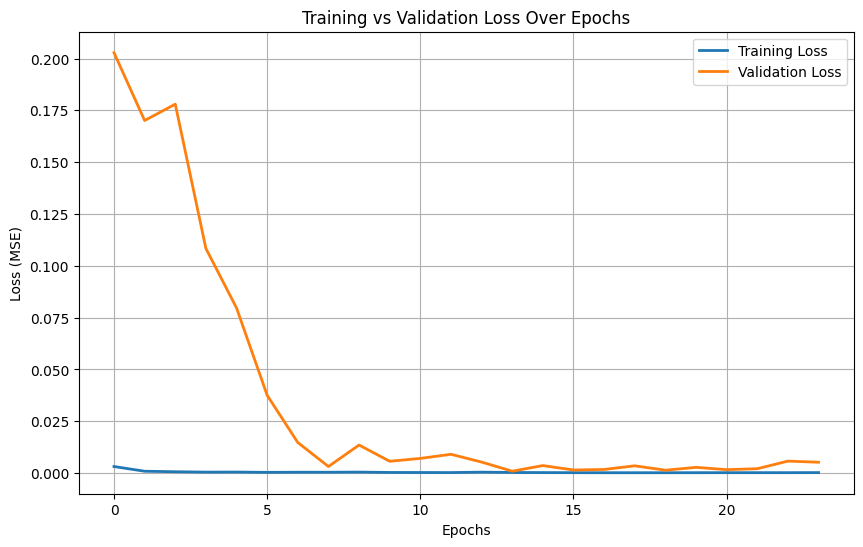

In [61]:
model, history, close_scaler, input_scaler = train_lstm_model(
    csv_path="dataset/AAPL_CleanedStockData.csv",
    sequence_length=100,
    batch_size=25,
    epochs=100,
    validation_split=0.2,
    patience=10,
    cutoff_date=cutoff_date
)

# === Save the trained model ===
model.save("models/lstm_attention_model.keras")
print("Model saved to models/lstm_attention_model.keras")

# === Plot and save training history ===
plot_training_history(history, save_path="training_history.png")

# Evaluating: 

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


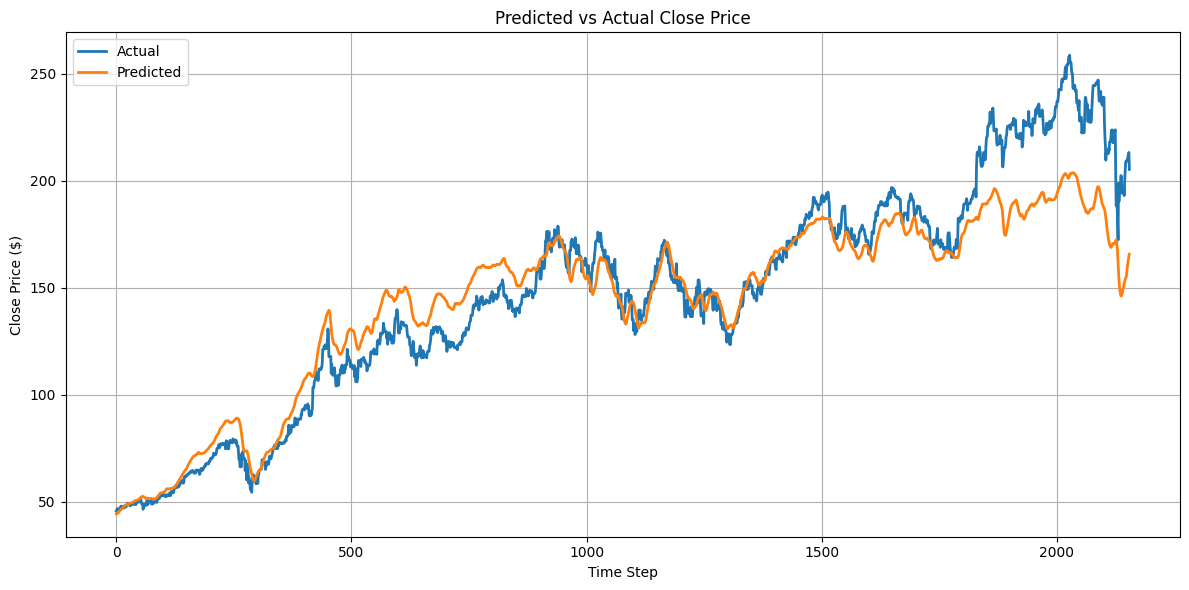

Mean Actual Price: $146.98
MAE: $12.85 (8.74%)
RMSE: $18.22 (12.39%)


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import joblib

# === SETTINGS ===
csv_path = 'dataset/AAPL_CleanedStockData.csv'
model_path = 'models/lstm_attention_model.keras'
close_scaler_path = 'models/close_only_scaler.save'
input_scaler_path = 'models/input_feature_scaler.save'
features = ['Close', 'Open', 'Range', 'MA20', 'MA50']
sequence_length = 100

# === Load everything ===
data = pd.read_csv(csv_path).drop(columns=['Date'])
close_scaler = joblib.load(close_scaler_path)
input_scaler = joblib.load(input_scaler_path)
model = load_model(model_path)

# === Preprocess ===
input_scaled = input_scaler.transform(data[features])
close_scaled = close_scaler.transform(data[['Close']])

X, y = [], []
for i in range(sequence_length, len(input_scaled)):
    X.append(input_scaled[i-sequence_length:i])
    y.append(close_scaled[i, 0])

X = np.array(X)
y = np.array(y)

# Use last 20% for testing
test_size = int(len(X) * 0.2)
X_test = X[-test_size:]
y_test = y[-test_size:]

# === Predict ===
y_pred_scaled = model.predict(X_test)
y_pred_real = close_scaler.inverse_transform(y_pred_scaled)
y_test_real = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# === Plot ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Actual', linewidth=2)
plt.plot(y_pred_real, label='Predicted', linewidth=2)
plt.title('Predicted vs Actual Close Price')
plt.xlabel('Time Step')
plt.ylabel('Close Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Metrics ===
mean_price = np.mean(y_test_real)
mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
percent_mae = (mae / mean_price) * 100
percent_rmse = (rmse / mean_price) * 100

print(f"Mean Actual Price: ${mean_price:.2f}")
print(f"MAE: ${mae:.2f} ({percent_mae:.2f}%)")
print(f"RMSE: ${rmse:.2f} ({percent_rmse:.2f}%)")

In [63]:
def predict_next_day_price(current_date: str):
    import pandas as pd
    import numpy as np
    import joblib
    import matplotlib.pyplot as plt
    from tensorflow.keras.models import load_model

    # === Config ===
    sequence_length = 100
    features = ['Close', 'Open', 'Range', 'MA20', 'MA50']

    # === Load model and scalers ===
    model = load_model('models/lstm_attention_model.keras')
    close_scaler = joblib.load('models/close_only_scaler.save')
    input_scaler = joblib.load('models/input_feature_scaler.save')

    # === Load and prepare dataset ===
    df = pd.read_csv('dataset/AAPL_CleanedStockData.csv', parse_dates=['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # === Locate the current date ===
    idx = df.index[df['Date'] == pd.to_datetime(current_date)]
    if idx.empty or idx[0] < sequence_length or idx[0] + 1 >= len(df):
        raise ValueError(
            "Invalid current_date — must be at least 100 days into dataset and not the last date.")

    target_idx = idx[0]

    # === Prepare input for prediction ===
    window_df = df.iloc[target_idx-sequence_length:target_idx]
    input_features = input_scaler.transform(window_df[features])
    input_sequence = input_features.reshape(1, sequence_length, len(features))

    # === Predict next day's Close price ===
    pred_scaled = model.predict(input_sequence)[0, 0]
    predicted_price = close_scaler.inverse_transform([[pred_scaled]])[0, 0]

    # === Get actual price of the next day ===
    next_day_date = df.iloc[target_idx + 1]['Date'].date()
    actual_price = df.iloc[target_idx + 1]['Close']

    # === Output ===
    print(f"📅 Predicting Close on {next_day_date}")
    print(f"🔮 Predicted Close: ${predicted_price:.2f}")
    print(f"✅ Actual Close:    ${actual_price:.2f}")
    print(f"📉 Absolute Error:  ${abs(predicted_price - actual_price):.2f}")
    print(
        f"🔍 Relative Error:  {(abs(predicted_price - actual_price) / actual_price) * 100:.2f}%")
    

    return {
        "predicted_price": predicted_price,
        "actual_price": actual_price,
        "error": abs(predicted_price - actual_price),
        "relative_error": (abs(predicted_price - actual_price) / actual_price) * 100,
        "next_day_date": next_day_date
    }

In [55]:
predict_next_day_price("2025-03-02")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
📅 Predicting Close on 2025-03-03
🔮 Predicted Close: $206.61
✅ Actual Close:    $238.03
📉 Absolute Error:  $31.42
🔍 Relative Error:  13.20%


{'predicted_price': np.float64(206.60990790878554),
 'actual_price': np.float64(238.02999877929688),
 'error': np.float64(31.42009087051133),
 'relative_error': np.float64(13.200055048374077),
 'next_day_date': datetime.date(2025, 3, 3)}

In [64]:
def evaluate_random_predictions(
    csv_path='dataset/AAPL_CleanedStockData.csv',
    model_path='models/lstm_attention_model.keras',
    close_scaler_path='models/close_only_scaler.save',
    input_scaler_path='models/input_feature_scaler.save',
    cutoff_date='2015-01-01',
    num_samples=10,
    sequence_length=100
):
    import pandas as pd
    import numpy as np
    import joblib
    from tensorflow.keras.models import load_model
    from random import sample

    features = ['Close', 'Open', 'Range', 'MA20', 'MA50']

    # Load model and scalers
    model = load_model(model_path)
    close_scaler = joblib.load(close_scaler_path)
    input_scaler = joblib.load(input_scaler_path)

    # Load and filter data
    df = pd.read_csv(csv_path, parse_dates=['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    df = df[df['Date'] >= pd.to_datetime(cutoff_date)].reset_index(drop=True)

    if len(df) <= sequence_length + 1:
        raise ValueError("Not enough data after cutoff_date to sample.")

    # Valid sample indices: we need N days before and 1 day after
    valid_indices = list(range(sequence_length, len(df) - 1))
    selected_indices = sample(valid_indices, min(
        num_samples, len(valid_indices)))

    results = []

    for idx in selected_indices:
        window_df = df.iloc[idx-sequence_length:idx]
        input_features = input_scaler.transform(window_df[features])
        input_seq = input_features.reshape(1, sequence_length, len(features))

        pred_scaled = model.predict(input_seq)[0, 0]
        predicted_price = close_scaler.inverse_transform([[pred_scaled]])[0, 0]

        actual_price = df.iloc[idx + 1]['Close']
        predict_for_date = df.iloc[idx + 1]['Date'].date()

        results.append({
            'Date': predict_for_date,
            'Predicted': predicted_price,
            'Actual': actual_price,
            'Absolute Error': abs(predicted_price - actual_price),
            'Relative Error (%)': abs(predicted_price - actual_price) / actual_price * 100
        })

    return pd.DataFrame(results).sort_values('Date').reset_index(drop=True)

In [56]:
results = evaluate_random_predictions(cutoff_date=cutoff_date)
display(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


,Date,Predicted,Actual,Absolute Error,Relative Error (%)
0,2015-06-02,62.138449,29.144896,32.993553,113.205255
1,2015-08-24,59.547926,23.230431,36.317495,156.335867
2,2015-11-25,64.297420,26.703102,37.594318,140.786332
3,2016-05-19,73.767043,21.557901,52.209142,242.181004
4,2018-10-28,68.218441,51.412636,16.805806,32.688084
5,2019-01-07,66.016919,35.284363,30.732556,87.099650
6,2020-01-31,81.392864,74.933746,6.459118,8.619772
7,2020-11-06,109.986640,115.934158,5.947519,5.130083
8,2021-08-05,140.833065,144.104431,3.271366,2.270136
9,2023-11-25,187.929735,188.836243,0.906508,0.480050
